# Notebook `01_pre-processing.ipynb`

---

# 🧼 Nettoyage des données brutes et préparation du jeu analysable

Ce notebook constitue la **première étape du pipeline IA** : il vise à transformer les données brutes issues de la plateforme Fiverr (source : Kaggle) en un **jeu de données propre et cohérent**, prêt pour l’analyse statistique ou la modélisation.

## 🎯 Objectifs

- 📥 Charger et explorer les données d’origine
- 🧹 Supprimer les colonnes inutiles ou sans informations
- 🔤 Nettoyer les chaînes de caractères et uniformiser les formats
- 🧾 Corriger les incohérences dans les valeurs numériques (`Prix`, `Évaluation`, `Avis`, etc.)
- 🌡️ Identifier et traiter les valeurs manquantes (imputation KNN)
- 📦 Nettoyer les descriptions textuelles (stopwords, expressions Fiverr)
- 🔄 Convertir les types au format adéquat et créer des indicateurs synthétiques (`Fiabilité`)
- 💾 Exporter des fichiers prêts à l’emploi :  
    * `fiverr_cleaned.csv` et `fiverr_cleaned.parquet`
    * `fiverr_cleaned_transformed.csv` et `fiverr_cleaned_transformed.parquet`

## ✅ Compétences mobilisées

- **Bloc 3 — C2** : Préparer et transformer des données pour les adapter à un modèle d’apprentissage automatique (nettoyage, gestion des valeurs manquantes, standardisation…)
- **Bloc 5 — C1** : Nettoyer des données non structurées (textes) en vue de leur vectorisation pour des modèles NLP
- **Bloc 5 — C4** *(indirectement)* : Anticiper le format et la structure nécessaires à un déploiement NLP (embeddings, fiabilité vectorisable, formats compatibles Gradio)

🧠 *Ce notebook constitue la base de données nettoyée utilisée dans toutes les étapes ultérieures du projet IA.*

---

## 🧭 Sommaire

1. [📦 Import des bibliothèques nécessaires](#-1-import-des-bibliotheques-necessaires)  
2. [💾 Récupération des données Fiverr depuis Kaggle](#2-récupération-des-données-fiverr-depuis-kaggle)  
3. [📂 Chargement des données brutes Fiverr dans un DataFrame Pandas](#3-chargement-des-données-brutes-fiverr-dans-un-dataframe-pandas)  
4. [🏷️ Nettoyage structurel : renommage, filtrage, correction des niveaux](#4-nettoyage-structurel--renommage-filtrage-correction-des-niveaux)  
5. [💰 Nettoyage et formatage de la colonne `Prix`](#5-nettoyage-et-formatage-de-la-colonne-prix)  
6. [🌟 Traitement de la colonne `gigrating` : Évaluation et nombre d’évaluation](#6-traitement-de-la-colonne-gigrating--évaluation-et-nombre-dévaluation)  
7. [🗑️ Suppression des colonnes inutiles : `gigrating` et `Lien`](#7-suppression-des-colonnes-inutiles--gigrating-et-lien)  
8. [🧹 Nettoyage des descriptions textuelles](#8-nettoyage-des-descriptions-textuelles)  
9. [🧪 Analyse exploratoire initiale du dataset](#9-analyse-exploratoire-initiale-du-dataset)  
10. [📊 Analyse statistique du dataset](#10-analyse-statistique-du-dataset)  
11. [🔎 Analyse des valeurs uniques par colonne](#11-analyse-des-valeurs-uniques-par-colonne)  
12. [🌡️ Analyse des valeurs manquantes du dataset](#12-analyse-des-valeurs-manquantes-du-dataset)  
13. [📉 Analyse des valeurs manquantes du dataset en %](#13-analyse-des-valeurs-manquantes-du-dataset-en-)  
14. [📉 Analyse des outliers des colonnes numériques](#14-analyse-des-outliers-des-colonnes-numériques)  
15. [📊 Analyse des distributions des valeurs numériques du dataset](#15-analyse-des-distributions-des-valeurs-numériques-du-dataset)  
16. [👥 Analyse de la répartition des vendeurs selon leur niveau](#16-analyse-de-la-répartition-des-vendeurs-selon-leur-niveau)  
17. [🧩 Imputation des valeurs manquantes de la variable catégorielle `Niveau` via KNN](#17-imputation-des-valeurs-manquantes-de-la-variable-catégorielle-niveau-via-knn)  
18. [✅ Vérification finale des valeurs manquantes après imputation](#18-vérification-finale-des-valeurs-manquantes-après-imputation)  
19. [🧺 Suppression des lignes non exploitables (`Niveau == "Clients"`)](#19-suppression-des-lignes-non-exploitables-niveau--clients)  
20. [🔧 Nettoyage des données](#20-nettoyage-des-données)  
21. [📈 Visualisation des distributions](#21-visualisation-des-distributions)  
22. [🧮 Création d’un indicateur synthétique de fiabilité](#22-création-dun-indicateur-synthétique-de-fiabilité)  
23. [🧹 Nettoyage avancé de la colonne `Description` : suppression des mots inutiles (stopwords)](#23-nettoyage-avancé-de-la-colonne-description--suppression-des-mots-inutiles-stopwords)  
24. [📊 Analyse exploratoire : Prix, Niveau et Fiabilité](#24-analyse-exploratoire--prix-niveau-et-fiabilité)  
25. [💾 Export du fichier nettoyé](#25-export-du-fichier-nettoyé)  
26. [🔄 Transformation avancée des données pour la modélisation](#26-transformation-avancée-des-données-pour-la-modélisation)  
27. [📊 Visualisation après nettoyage des outliers](#27-visualisation-après-nettoyage-des-outliers)  
28. [🔍 Analyse comparative avant et après suppression des outliers](#28-analyse-comparative-avant-et-après-suppression-des-outliers)  
29. [🧾 Conclusion du prétraitement](#29-conclusion-du-prétraitement)  
30. [✅ Checklist de fin de prétraitement des données](#30-checklist-de-fin-de-prétraitement-des-données)  

---

## 📦 1. Import des bibliothèques nécessaires

Ce notebook utilise un ensemble de bibliothèques Python pour réaliser les étapes de **prétraitement**, **nettoyage**, **imputation** et **visualisation** des données issues de Fiverr.

### 📚 1.1. Choix et justification

- **`re`** : Manipulation de chaînes via des expressions régulières (suppression de ponctuations, nettoyage de texte).
- **`os`** : Accès au système de fichiers (création de répertoires, lecture de fichiers).
- **`pandas`** : Outil central pour manipuler, filtrer et transformer les données tabulaires.
- **`numpy`** : Support pour les tableaux et le calcul numérique, notamment avec `np.nan`.
- **`matplotlib.pyplot`** : Visualisation basique de données (histogrammes, courbes).
- **`seaborn`** : Visualisation statistique riche, notamment pour les heatmaps et boxplots.
- **`unicodedata`** : Nettoyage des caractères spéciaux et accents (Unicode).
- **`nltk`** : Librairie NLP (traitement du langage), utile pour les étapes de vectorisation textuelle.
- **`nltk.corpus.stopwords`** : Liste de mots vides en français à supprimer pour nettoyer les descriptions.
- **`sklearn.preprocessing.LabelEncoder`** : Conversion de labels catégoriels en codes numériques.
- **`sklearn.impute.KNNImputer`** : Remplissage des valeurs manquantes à partir de voisins les plus proches.
- **`sklearn.feature_extraction.text.ENGLISH_STOP_WORDS`** : Stopwords anglais, utilisés pour comparer ou compléter le nettoyage.
- **`kaggle.api.kaggle_api_extended.KaggleApi`** : Utilisé pour automatiser le téléchargement de données depuis la plateforme Kaggle.

✅ Toutes ces bibliothèques sont réellement utilisées dans ce notebook et nécessaires pour l'ensemble du pipeline de traitement.

---

### 🐍 1.2. Script d'import des bibliothèques

In [55]:
# 🧰 Importation des bibliothèques nécessaires

import re                                # Traitement de texte avec expressions régulières
import os                                # Gestion des chemins et fichiers locaux
import pandas as pd                      # Manipulation de données tabulaires
import numpy as np                       # Calculs numériques et tableaux
import matplotlib.pyplot as plt          # Visualisation de données (graphiques)
import seaborn as sns                    # Visualisation statistique avancée (intégration avec pandas)
import unicodedata                       # Normalisation des caractères Unicode (ex. : suppression des accents)

import nltk                              # Traitement du langage naturel (NLP)
from nltk.corpus import stopwords        # Liste de stopwords français pour le nettoyage textuel

from sklearn.preprocessing import LabelEncoder        # Encodage de variables catégorielles
from sklearn.impute import KNNImputer                 # Imputation des valeurs manquantes par les k plus proches voisins
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS  # Stopwords anglais intégrés à sklearn

from kaggle.api.kaggle_api_extended import KaggleApi  # API Kaggle pour le téléchargement automatique des datasets

### 🗂️ 1.3 Création de l'arborescence de dossiers

Pour assurer une bonne organisation du projet, cette cellule crée automatiquement les répertoires nécessaires, s’ils n’existent pas encore :

- `data/` : pour les jeux de données bruts et transformés
  - `data/predictions_grid/` : pour stocker les fichiers de prédiction des grilles de modèles
- `models/` : pour les modèles enregistrés
  - `models/regression/` : modèles de régression
  - `models/classification/` : modèles de classification
- `flagged/` : pour les fichiers de log issus de l'application Gradio
- `img/` : pour stocker les illustrations (captures d'écran, visuels de l'app, etc.)

### 🐍 Script Python utilisé

In [ ]:
DATA_FOLDER = "data"

os.makedirs(DATA_FOLDER, exist_ok=True)
os.makedirs("data/predictions_grid", exist_ok=True)

os.makedirs("models", exist_ok=True)
os.makedirs("models/classification", exist_ok=True)
os.makedirs("models/regression", exist_ok=True)

os.makedirs("flagged", exist_ok=True)
os.makedirs("img", exist_ok=True)

---

## 💾 2. Récupération des données Fiverr depuis Kaggle

Avant de démarrer le prétraitement, nous téléchargeons automatiquement le dataset depuis **Kaggle** à l’aide de l’API `KaggleApi`.  
Cette méthode garantit que nous travaillons avec une **source de données propre, fiable et traçable**.

### ❓ 2.1. Pourquoi automatiser cette étape ?

- Évite le téléchargement manuel du fichier CSV.
- Permet une **intégration fluide dans un pipeline reproductible** (script Python, notebook, workflow cloud…).
- Supprime les versions précédentes du fichier pour éviter les conflits ou doublons.
- Assure une **traçabilité claire** de la provenance des données.

### 🎯 2.2. Comportement attendu

- Authentification à l’API Kaggle.
- Création du dossier local `data/` s’il n’existe pas.
- Téléchargement et **décompression automatique** du dataset `fiverr-data-gigs`.
- Suppression du fichier `fiverr-data-gigs-cleaned.csv` s’il est déjà présent dans `data/`.
- Affichage des fichiers extraits dans la console pour vérification rapide.

---

### 🐍 2.3. Script de téléchargement et gestion des fichiers

In [56]:
# 🔐 Initialisation et authentification auprès de l’API Kaggle
api = KaggleApi()
api.authenticate()

# 📁 Définition du dataset à télécharger et du chemin de destination
dataset = "muhammadadiltalay/fiverr-data-gigs"
# DATA_FOLDER = "data"

# ⬇️ Téléchargement et décompression du dataset depuis Kaggle
api.dataset_download_files(dataset, path=DATA_FOLDER, unzip=True)

# 📄 Construction du chemin vers le fichier CSV à supprimer si besoin
file_path = os.path.join(DATA_FOLDER, "fiverr-data-gigs-cleaned.csv")

# 🗑️ Suppression du fichier CSV s’il existe déjà
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Fichier supprimé : {file_path}")
else:
    print(f"Le fichier n'existe pas : {file_path}")

# 📜 Liste les fichiers présents dans le dossier pour vérification
for filename in os.listdir(DATA_FOLDER):
    print("Fichier trouvé :", filename)

Fichier supprimé : data\fiverr-data-gigs-cleaned.csv
Fichier trouvé : fiverr-data-gigs.csv
Fichier trouvé : predictions_grid
Fichier trouvé : regression_embed


---

## 📂 3. Chargement des données brutes Fiverr dans un DataFrame Pandas

Nous commençons par importer les **données brutes** à partir du fichier CSV original téléchargé depuis Kaggle.  
Aucune transformation ni suppression n’a encore été effectuée à ce stade.

### ❓ 3.1. Pourquoi cette étape maintenant ?

- Il s'agit du **point d’entrée du pipeline de traitement**.
- Permet de **valider l’encodage** du fichier et détecter d’éventuels problèmes (types mixtes, colonnes mal formatées, etc.).
- Fournit un **aperçu rapide de la structure** des données disponibles via `df.head()`.

### 🎯 3.2. Résultat attendu

- Les données sont chargées dans un DataFrame nommé `df`.
- Les **trois premières lignes** sont affichées pour vérification.
- L’encodage et la structure du fichier CSV sont validés avant tout traitement ultérieur.

---

### 🐍 3.3. Script de chargement des données brutes

In [57]:
# 📥 Chargement du fichier CSV brut dans un DataFrame pandas
df = pd.read_csv(
    'data/fiverr-data-gigs.csv',  # 📁 Chemin relatif vers le fichier source
    encoding='UTF-8',             # 🌐 Encodage UTF-8 pour gérer les caractères accentués
    low_memory=False              # 🔄 Lecture complète du fichier pour éviter les conflits de type sur les grandes colonnes
)

# 👁️ Affichage des 3 premières lignes du jeu de données pour aperçu
df.head(3)

,Title,Title_URL,gigrating,_5fo9i5,Price
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,5.0(56),Level 2 Seller,"PKR 8,701"
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,5.0(1k+),Top Rated Seller,"PKR 3,263"
2,"I will do web scraping , data scraping, scrapi...",https://www.fiverr.com/kodweb/do-web-scraping-...,5.0(63),Level 2 Seller,"PKR 2,176"


---

## 🏷️ 4. Nettoyage structurel : renommage, filtrage, correction des niveaux

### ❓ 4.1. Pourquoi cette étape maintenant ?

Avant d'entamer les analyses, il est essentiel d'assurer une **structure claire et cohérente** du jeu de données :
- Renommer les colonnes avec des intitulés explicites et interprétables.
- Supprimer les lignes contenant des niveaux non exploitables (`"Clients"`).
- Standardiser la variable `Niveau` pour qu’elle soit utilisable en modélisation.

### 🛠️ 4.2. Actions réalisées

- Renommage des colonnes :
  - `Title` → `Description`
  - `Price` → `Prix`
  - `Title_URL` → `Lien`
  - `_5fo9i5` → `Niveau`
- Suppression des lignes où `Niveau == "Clients"` (hors périmètre d’analyse).
- Remplacement des labels anglais par des codes numériques :
  - `"Level 1 Seller"` → `1`
  - `"Level 2 Seller"` → `2`
  - `"Top Rated Seller"` → `3`

### 🎯 4.3. Résultat attendu

- Des noms de colonnes plus lisibles.
- Une colonne `Niveau` nettoyée et encodée de manière cohérente.
- Un jeu de données prêt pour les premières analyses statistiques ou la visualisation.

---

### 🐍 4.4. Script exécuté

In [58]:
df.rename(columns={'Title': 'Description'}, inplace=True)
df.rename(columns={'Title_URL': 'Lien'}, inplace=True)
df.rename(columns={'_5fo9i5': 'Niveau'}, inplace=True)
df.rename(columns={'Price': 'Prix'}, inplace=True)

# vérification des noms de colonnes
print("Colonnes :", df.columns.tolist())

# Suppression des lignes avec "Clients"
df = df[df['Niveau'] != "Clients"]

# Remplacement des libellés anglais par des labels numériques
df['Niveau'] = df['Niveau'].replace({
    "Level 1 Seller": 1,
    "Level 2 Seller": 2,
    "Top Rated Seller": 3
})
# Encodage numérique :
# 1 = Level 1 Seller, 2 = Level 2 Seller, 3 = Top Rated Seller

display(df.head(25))

Colonnes : ['Description', 'Lien', 'gigrating', 'Niveau', 'Prix']


,Description,Lien,gigrating,Niveau,Prix
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,5.0(56),2.0,"PKR 8,701"
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,5.0(1k+),3.0,"PKR 3,263"
2,"I will do web scraping , data scraping, scrapi...",https://www.fiverr.com/kodweb/do-web-scraping-...,5.0(63),2.0,"PKR 2,176"
3,"I will do python web scraping , data entry , a...",https://www.fiverr.com/asad__haadi/do-web-scra...,5.0(266),2.0,"PKR 1,088"
4,I will data scraping web site scraping and dat...,https://www.fiverr.com/yourbuddy/web-scraping-...,4.9(275),2.0,"PKR 4,351"
5,"I will do perfect web scraping, data mining fo...",https://www.fiverr.com/adeel085/do-perfect-web...,5.0(181),2.0,"PKR 2,176"
6,I will write web scraper using python for you,https://www.fiverr.com/naumansharif111/write-s...,5.0(211),3.0,"PKR 10,876"
7,"I will do web scraping, crawling and data mini...",https://www.fiverr.com/prakriteekhanal/do-web-...,5.0(398),3.0,"PKR 17,401"
8,"I will do website scraping, python scripts aut...",https://www.fiverr.com/alifarslan/deploy-pytho...,5.0(61),2.0,"PKR 4,351"
10,I will compose advanced excel formulas and aut...,https://www.fiverr.com/excel_expert/compose-ad...,5.0(861),2.0,"PKR 1,088"


---

## 💰 5. Nettoyage et formatage de la colonne `Prix`

### ❓ 5.1. Pourquoi cette étape maintenant ?

La colonne `Prix` contient des valeurs issues du scraping, avec des **symboles monétaires**, **virgules** ou **points multiples**, ce qui empêche toute analyse numérique directe.  
Il est essentiel de la nettoyer pour :

- La convertir en **type numérique (`float`)** utilisable par les modèles.
- Supprimer les caractères parasites (€, espaces…).
- Gérer proprement les **valeurs vides ou invalides**.
- Préparer les étapes de visualisation, normalisation ou imputation.

### 🎯 5.2. Résultat attendu

Après traitement :
- Les symboles et caractères non numériques sont supprimés.
- Les virgules sont remplacées par des points pour un format décimal conforme (`.`).
- Les éventuels multiples points sont corrigés (seul le dernier est conservé).
- Les chaînes vides sont transformées en `NaN`.
- La colonne est convertie en `float` pour les traitements numériques.

---

### 🐍 5.3. Script de nettoyage et formatage

In [59]:
# 🧽 Nettoyage et conversion de la colonne 'Prix'
df['Prix'] = (
    df['Prix']
    .astype(str)                                   # 🔄 Conversion en chaîne pour traitement regex
    .str.replace(r'[^\d,]', '', regex=True)        # 🔤 Supprime tout sauf chiffres et virgules (ex : €)
    .str.replace(',', '.', regex=False)            # 🔁 Convertit les virgules en points pour un format décimal standard
    .str.replace(r'\.(?=.*\.)', '', regex=True)     # 🧹 Supprime tous les points sauf le dernier (évite erreurs float)
    .replace('', np.nan)                            # ❓ Transforme les chaînes vides en NaN
    .astype(float)                                  # 🔢 Conversion finale en float
)

# 🔍 Vérification visuelle des premiers résultats
print(df['Prix'].head())

0    8.701
1    3.263
2    2.176
3    1.088
4    4.351
Name: Prix, dtype: float64


---

## 🌟 6. Traitement de la colonne `"gigrating"` : Évaluation et nombre d'évaluations

### ❓ 6.1. Pourquoi cette étape maintenant ?

La colonne `gigrating` regroupe deux informations utiles dans une seule chaîne de texte :
- Le **score d’évaluation** (exemple : `4.9`)
- Le **nombre total d’avis** (souvent sous forme abrégée comme `(3k+)`)

Afin de pouvoir exploiter ces deux indicateurs séparément :
- Le score est extrait dans une nouvelle colonne `Evaluation` (type `float`)
- Le nombre d’avis est converti et nettoyé dans une colonne `Rating_Count` (également `float`)

Cela facilite les traitements statistiques, les visualisations, ou leur intégration dans un futur modèle prédictif.

### 🎯 6.2. Résultat attendu

| gigrating     | Evaluation | Rating_Count |
|---------------|------------|--------------|
| `4.9 (3k+)`   | 4.9        | 3000.0       |
| `4.7 (125)`   | 4.7        | 125.0        |
| `5.0`         | 5.0        | `NaN`        |
| `NaN`         | `NaN`      | `NaN`        |

- `Evaluation` contient uniquement le score.
- `Rating_Count` contient le nombre d’avis, transformé en valeur numérique (conversion automatique des notations avec `k`).

---

### 🐍 6.3. Script de traitement de la colonne `"gigrating"`

In [60]:
# 🎯 Extraction du score de la colonne 'gigrating' (ex : "4.9 (3k+)" → 4.9)
df['Evaluation'] = df['gigrating'].str.extract(r'^([\d.]+)').astype(float)

# 🛠️ Fonction personnalisée pour extraire et convertir le nombre d’avis
def parse_review_count(s):
    if pd.isna(s):
        return np.nan  # Cas de valeur manquante
    match = re.search(r'\(([^)]+)\)', s)  # Extrait le contenu entre parenthèses
    if not match:
        return np.nan
    val = match.group(1).lower().replace('+', '')  # Nettoyage : supprime '+' et passe en minuscule
    if 'k' in val:
        return float(val.replace('k', '')) * 1000  # Conversion "3k" → 3000
    return float(val)  # Cas standard (ex. "125")

# 📊 Application de la fonction à chaque ligne pour créer la colonne 'Rating_Count'
df['Rating_Count'] = df['gigrating'].apply(parse_review_count)

---

## 🗑️ 7. Suppression des colonnes inutiles : `gigrating` et `Lien`

### ❓ 7.1. Pourquoi supprimer ces colonnes ?

- La colonne `gigrating` a déjà été traitée :
  - Le **score d’évaluation** a été extrait dans la colonne `Evaluation`
  - Le **nombre d’avis** a été transféré dans la colonne `Rating_Count`
  → Elle ne contient donc plus aucune information utile.

- La colonne `Lien` (anciennement `Title_URL`) est un **hyperlien vers l’annonce Fiverr**.  
  Étant donné qu’elle n’est **pas utilisée dans l’analyse ou la modélisation**, elle est supprimée pour alléger le dataset.

### 🎯 7.2. Résultat attendu

| Description                    | Evaluation | Rating_Count |
|--------------------------------|------------|--------------|
| Je vais créer votre logo...    | 4.9        | 3000.0       |
| Je vais concevoir un site web | 4.7        | 125.0        |

- ✅ La colonne `gigrating` a disparu.
- ✅ La colonne `Lien` est également supprimée.

---

### 🐍 7.3. Script de suppression

In [61]:
# 🗑️ Suppression des colonnes devenues inutiles
df.drop(columns=['gigrating'], inplace=True)  # La donnée a été extraite dans d'autres colonnes
df.drop(columns=['Lien'], inplace=True)       # La colonne Lien n'est pas utilisée dans l'analyse

# 👁️ Vérification rapide du résultat
df.head(2)

,Description,Niveau,Prix,Evaluation,Rating_Count
0,"I will do excel formulas, vba macros, charts, ...",2.0,8.701,5.0,56.0
1,"I will do data mining, web scraping, data extr...",3.0,3.263,5.0,1000.0


---

## 🧹 8. Nettoyage des descriptions textuelles

### ❓ 8.1. Pourquoi nettoyer le texte maintenant ?

La colonne `Description` contient des titres de services rédigés en texte libre, avec :
- des **majuscules**,  
- des **accents**,  
- de la **ponctuation**,  
- et parfois des **espaces superflus**.

Le nettoyage est indispensable avant toute étape de vectorisation (TF-IDF, embeddings...) pour :
- Éviter que des variantes lexicales soient traitées comme des mots différents,
- **Standardiser** les chaînes textuelles,
- Réduire le **bruit textuel** dans les futurs modèles.

### 🔧 8.2. Étapes de nettoyage effectuées

La fonction `clean_text()` applique les transformations suivantes :
1. Conversion du texte en **minuscules**
2. **Suppression des accents** (ex. : é → e)
3. **Retrait de la ponctuation**
4. **Nettoyage des espaces multiples ou en trop**

### 🎯 8.3. Résultat attendu

Le texte devient clair, homogène et prêt pour la modélisation.  
Exemples de transformation :

| Texte original                                | Après nettoyage                        |
|----------------------------------------------|----------------------------------------|
| `"Création de logo professionnel !"`          | `"creation de logo professionnel"`     |
| `"Je vais réaliser votre site web..."`        | `"je vais realiser votre site web"`    |

---

### 🐍 8.4. Script de nettoyage

In [62]:
# ✨ Fonction de nettoyage du texte dans la colonne 'Description'
def clean_text(text):
    text = str(text).lower()  # Conversion en minuscules
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")  # Suppression des accents
    text = re.sub(r'[^\w\s]', ' ', text)  # Suppression de la ponctuation (remplacée par espace)
    text = re.sub(r'\s+', ' ', text).strip()  # Suppression des espaces multiples et nettoyage final
    return text

# 🧼 Application de la fonction à chaque ligne de la colonne 'Description'
df['Description'] = df['Description'].apply(clean_text)

# 👁️ Affichage d’un échantillon de 3 lignes pour contrôle
display(df.head(3))

,Description,Niveau,Prix,Evaluation,Rating_Count
0,i will do excel formulas vba macros charts for...,2.0,8.701,5.0,56.0
1,i will do data mining web scraping data extrac...,3.0,3.263,5.0,1000.0
2,i will do web scraping data scraping scraping ...,2.0,2.176,5.0,63.0


---

## 🧪 9. Analyse exploratoire initiale du dataset

### ❓ 9.1. Pourquoi cette étape maintenant ?

Avant d’engager les traitements plus poussés, il est indispensable de **faire un état des lieux du dataset brut**.  
Cela permet de détecter d’éventuels problèmes structurels ou qualitatifs tels que :
- des **valeurs manquantes** ou mal encodées,
- des **types de colonnes non conformes** (ex. chaîne au lieu de nombre),
- des **lignes en double**,
- ou des colonnes inexploitables.

Cette étape permet d’**orienter les prochaines opérations de nettoyage** et d’anticiper les risques lors de la modélisation.

### 🎯 9.2. Résultat attendu

#### 📐 9.2.1. Dimensions et types
- Nombre total de lignes et de colonnes.
- Types de données (`object`, `float64`, `int64`, etc.) pour chaque variable.

#### 🧩 9.2.2. Valeurs manquantes
- Taux (%) de cellules vides par colonne (en pourcentage du total).

#### 📑 9.2.3. Doublons
- Nombre total de lignes dupliquées (exactement identiques à une autre ligne).

---

### 🐍 9.3. Script d’analyse exploratoire

In [63]:
# 📏 Dimensions du DataFrame
# - df.shape[0] : nombre de lignes
# - df.shape[1] : nombre de colonnes
print("******************************************************************************")
print("Dimensions du Dataframe")
print(f"Lignes : {df.shape[0]}\nColonnes : {df.shape[1]}\n")

# 👁️ Aperçu rapide du contenu avec les 3 premières lignes
display(df.head(3))

# 🔍 Types de données par colonne
# - df.dtypes : retourne le type de chaque colonne (ex. object, float64, int64)
print("\n******************************************************************************")
print("Types de données pour chaque colonne du Dataframe\n")
print(df.dtypes)

# 🧮 Pourcentage de valeurs manquantes par colonne
# - df.isnull() : masque booléen (True si valeur manquante)
# - .mean() * 100 : calcule le pourcentage de NaN pour chaque colonne
missing_percent = df.isnull().mean() * 100
print("\n******************************************************************************")
print("Pourcentage de valeurs manquantes\n")
print(missing_percent.sort_values(ascending=False))

# ♻️ Détection des doublons
# - df.duplicated() : retourne un masque booléen pour les lignes dupliquées
# - .sum() : nombre total de lignes dupliquées
print("\n******************************************************************************")
print(f"Nombre de lignes dupliquées : {df.duplicated().sum()}")

******************************************************************************
Dimensions du Dataframe
Lignes : 1252
Colonnes : 5



,Description,Niveau,Prix,Evaluation,Rating_Count
0,i will do excel formulas vba macros charts for...,2.0,8.701,5.0,56.0
1,i will do data mining web scraping data extrac...,3.0,3.263,5.0,1000.0
2,i will do web scraping data scraping scraping ...,2.0,2.176,5.0,63.0



******************************************************************************
Types de données pour chaque colonne du Dataframe

Description      object
Niveau          float64
Prix            float64
Evaluation      float64
Rating_Count    float64
dtype: object

******************************************************************************
Pourcentage de valeurs manquantes

Niveau          66.054313
Evaluation      50.239617
Rating_Count    50.239617
Description      0.000000
Prix             0.000000
dtype: float64

******************************************************************************
Nombre de lignes dupliquées : 41


---

## 📊 10. Analyse statistique du dataset

### ❓ 10.1. Pourquoi cette étape maintenant ?

Après avoir validé la structure du jeu de données, il est nécessaire d’obtenir une **vue statistique globale** des variables numériques.  
Cette étape permet de :

- détecter des **valeurs aberrantes** (ex. : prix anormalement bas ou élevés),
- évaluer la **dispersion des données** (écart-type, quartiles),
- identifier d’éventuelles variables trop constantes ou déséquilibrées.

### 🎯 10.2. Résultat attendu

L'appel à `df.describe()` fournit les mesures suivantes :

| Statistique | Interprétation |
|-------------|----------------|
| `count`     | Nombre de valeurs valides (non nulles) |
| `mean`      | Moyenne arithmétique |
| `std`       | Écart-type (mesure de la dispersion) |
| `min`/`max` | Valeurs extrêmes observées |
| `25%`, `50%`, `75%` | Quartiles : Q1, médiane, Q3 |

Ces indicateurs servent à :
- **repérer les distributions anormales** (valeurs très éloignées de la médiane),
- **anticiper un traitement par normalisation ou transformation** (log, standard scaling),
- orienter les futures décisions de nettoyage et de préparation du modèle.

---

### 🐍 10.3. Script d’analyse statistique

In [64]:
# 📊 Affichage des statistiques descriptives pour toutes les colonnes numériques du DataFrame
# - df.describe() retourne :
#   * count : nombre de valeurs non nulles
#   * mean : moyenne
#   * std : écart-type
#   * min, 25%, 50%, 75%, max : quartiles et extrêmes
# ➤ Utile pour repérer la dispersion des données et détecter les valeurs atypiques
print("Statistiques des colonnes numériques du Dataframe")
df.describe()

Statistiques des colonnes numériques du Dataframe


,Niveau,Prix,Evaluation,Rating_Count
count,425.000000,1252.000000,623.000000,623.000000
mean,1.640000,14.924895,4.954735,78.467095
std,0.610289,70.972708,0.187484,180.270871
min,1.000000,1.088000,1.000000,1.000000
25%,1.000000,2.176000,5.000000,4.000000
50%,2.000000,4.351000,5.000000,16.000000
75%,2.000000,10.876000,5.000000,56.000000
max,3.000000,2175.105000,5.000000,1000.000000


---

## 🔎 11. Analyse des valeurs uniques par colonne

### ❓ 11.1. Pourquoi cette étape ?

Analyser le nombre de valeurs distinctes dans chaque colonne permet de :

- Repérer les **colonnes constantes**, c’est-à-dire avec une seule valeur, qui n’apportent **aucune information discriminante**.
- Identifier les colonnes **à faible variance** (ex. : 2 ou 3 modalités seulement), souvent peu utiles pour l’apprentissage automatique.
- Détecter les **colonnes catégorielles candidates** à une transformation (ex. encodage One-Hot ou Label Encoding).

C’est une étape clé pour le **nettoyage des variables non informatives**.

### 🎯 11.2. Résultat attendu

- Affichage d’un tableau listant chaque colonne avec son **nombre de valeurs uniques**.
- Les colonnes avec peu de diversité (constantes ou quasi constantes) seront **facilement identifiables en haut**.
- Cela permet d’orienter les décisions de **suppression ou transformation**.

---

### 🐍 11.3. Script Python

In [65]:
# 🔎 Comptage du nombre de valeurs distinctes dans chaque colonne
# - df.nunique() : retourne le nombre de valeurs uniques par colonne
# - .sort_values() : trie les résultats par ordre croissant
# ➤ Permet de repérer les colonnes constantes ou faiblement informatives
print("Nombre de valeurs uniques par colonne\n")
print(df.nunique().sort_values())

Nombre de valeurs uniques par colonne

Niveau             3
Evaluation         9
Prix              56
Rating_Count     164
Description     1174
dtype: int64


---

## 🌡️ 12. Analyse des valeurs manquantes du dataset

### ❓ 12.1. Pourquoi cette étape maintenant ?

Bien que nous ayons déjà identifié les **pourcentages de valeurs manquantes**, une visualisation graphique permet d’aller plus loin en :

- repérant rapidement les **zones concentrées** en `NaN` (colonnes ou lignes spécifiques),
- détectant des **patterns anormaux** ou répétitifs (ex. : colonnes systématiquement ignorées),
- **priorisant** les colonnes à traiter dans les étapes d’imputation ou de suppression.

L’approche visuelle complète utilement l’analyse quantitative.

### 🎯 12.2. Résultat attendu

#### 🔥 12.2.1. Carte des valeurs manquantes

- Une **heatmap** où :
  - l’axe X représente les colonnes,
  - l’axe Y représente les lignes (observations),
  - les cellules colorées indiquent des valeurs manquantes (`NaN`).

Cette visualisation permet de :
- repérer d’un coup d’œil les **colonnes problématiques**,
- détecter d’éventuelles erreurs dans l’extraction ou le scraping initial.

---

### 🐍 12.3. Script d’analyse des valeurs manquantes

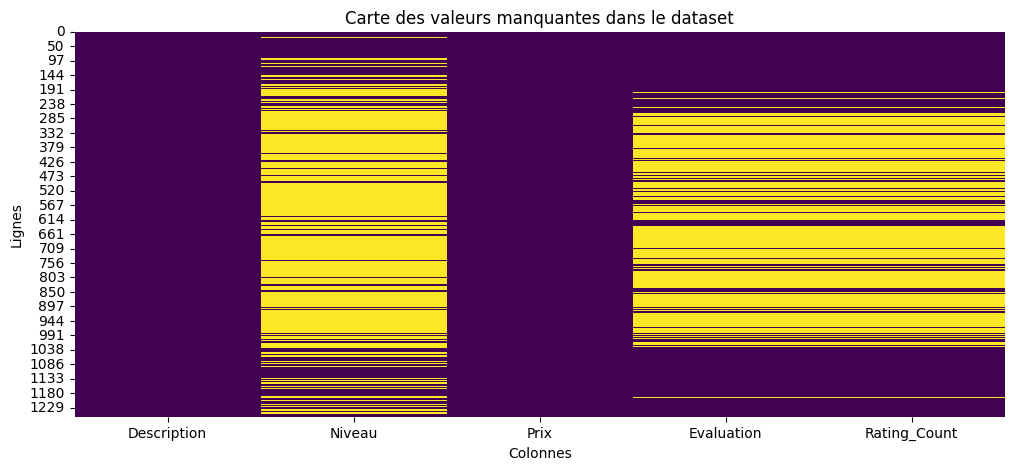

In [66]:
# 🖼️ Initialisation de la figure pour la visualisation
plt.figure(figsize=(12, 5))  # Largeur : 12, Hauteur : 5 (en pouces)

# 🔥 Heatmap des valeurs manquantes dans le DataFrame
# - df.isnull() : retourne un DataFrame booléen (True si NaN)
# - cbar=False : masque la barre de couleur à droite
# - cmap='viridis' : palette allant du noir au vert
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# 🏷️ Ajout du titre et des étiquettes d’axes
plt.title('Carte des valeurs manquantes dans le dataset')
plt.xlabel("Colonnes")
plt.ylabel("Lignes")

# 👁️ Affichage de la figure
plt.show()

---

## 📉 13. Analyse des valeurs manquantes du dataset en %

### ❓ 13.1. Pourquoi cette étape maintenant ?

Après la **détection globale** et la **visualisation ligne par ligne**, il est utile de **quantifier précisément** les colonnes les plus touchées par les valeurs manquantes.  
Cette étape permet de :

- Repérer les colonnes ayant un **taux critique de `NaN`**,
- **Prioriser** les traitements (suppression, imputation, exclusion…),
- Éclairer les futures décisions de nettoyage ou transformation.

### 🎯 13.2. Résultat attendu

#### 📊 Diagramme de valeurs manquantes

- Un **graphique en barres horizontales**, où chaque barre représente une colonne.
- L’axe X indique le **pourcentage de cellules vides**.
- Les colonnes sont **triées par importance décroissante**.
- La palette **rouge inversée (`Reds_r`)** attire l’attention sur les colonnes les plus affectées.

Ce graphique donne une **vue synthétique et hiérarchisée** des colonnes à surveiller en priorité.

---

### 🐍 13.3. Script d’analyse des valeurs manquantes en %

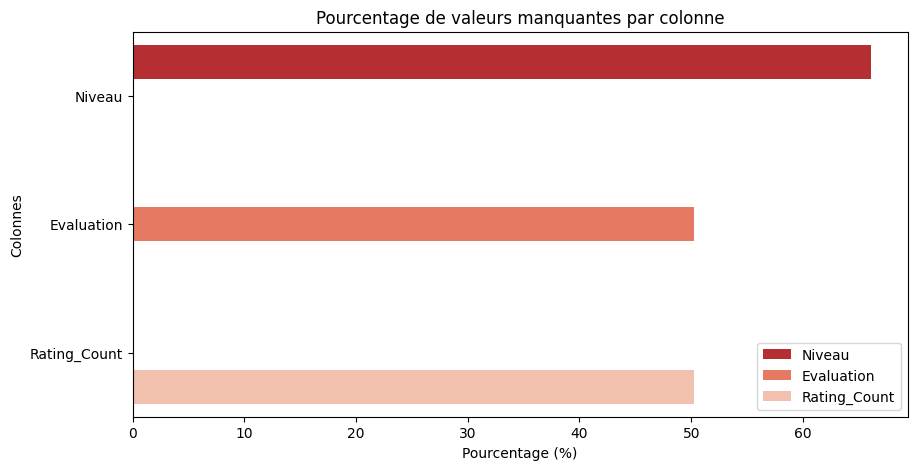

In [67]:
# 📊 Calcul du pourcentage de valeurs manquantes pour chaque colonne
missing_percent = df.isnull().mean() * 100

# 🧼 Filtrage : conserve uniquement les colonnes ayant au moins 1% de valeurs manquantes
# - .sort_values() : tri décroissant pour les plus problématiques en haut
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

# 🖼️ Initialisation du graphique
plt.figure(figsize=(10, 5))

# 📉 Affichage du pourcentage de valeurs manquantes par colonne (barres horizontales)
# - hue : pour que chaque barre ait une couleur unique
# - palette='Reds_r' : dégradé rouge inversé (plus foncé = plus critique)
sns.barplot(
    x=missing_percent.values,
    y=missing_percent.index,
    hue=missing_percent.index,
    palette="Reds_r"
)

# 🏷️ Titres et étiquettes
plt.title("Pourcentage de valeurs manquantes par colonne")
plt.xlabel("Pourcentage (%)")
plt.ylabel("Colonnes")

# 👁️ Affichage du graphique
plt.show()


---

## 📉 14. Analyse des outliers des colonnes numériques

### ❓ 14.1. Pourquoi cette étape maintenant ?  

L’analyse des **valeurs extrêmes (outliers)** est cruciale avant toute modélisation car ces valeurs :

- peuvent **biaiser les statistiques globales** (moyenne, écart-type...),
- sont souvent **mal gérées par les algorithmes sensibles aux distances** (ex. : KNN, régressions),
- peuvent révéler des **anomalies ou erreurs de saisie**.

L’objectif est ici de **visualiser la répartition** des variables clés et de décider d’un traitement adapté :  
conservation, transformation, ou suppression des données extrêmes.

### 🎯 14.2. Résultat attendu  

#### 🔬 14.2.1. Analyse visuelle des valeurs extrêmes

Trois **boxplots horizontaux** sont générés pour les variables numériques suivantes :

- `Prix`
- `Evaluation`
- `Rating_Count`

Chaque graphe est **zoomé sur une plage réaliste** :
- évite l’écrasement des distributions,
- rend les outliers visuellement détectables,
- facilite les décisions de nettoyage.

---

### 🐍 14.3. Script d'analyse des outliers des colonnes numériques

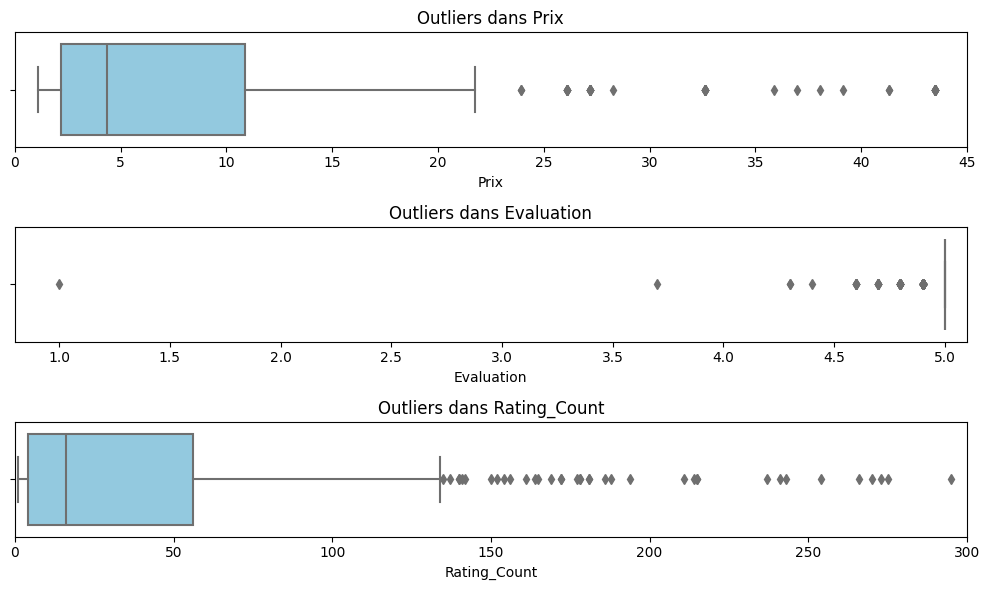

In [68]:
# 🔢 Sélection des colonnes numériques à analyser
numeric_cols = ['Prix', 'Evaluation', 'Rating_Count']

# 🔍 Définition de plages personnalisées pour zoomer sur les zones pertinentes
x_limits = [
    (0, 45),     # Zoom sur les prix réalistes (exclut valeurs aberrantes > 100)
    (0.8, 5.1),  # Échelle typique des évaluations (0 à 5)
    (0, 300)     # Nombre d’avis raisonnable (élimine les cas à plusieurs milliers)
]

# 🖼️ Initialisation de la figure globale
plt.figure(figsize=(10, 6))

# 🔁 Boucle sur les colonnes et leurs plages de zoom associées
for i, (col, xlim) in enumerate(zip(numeric_cols, x_limits), 1):
    
    # 📊 Sous-graphique positionné sur la i-ème ligne (3 lignes, 1 colonne)
    plt.subplot(3, 1, i)
    
    # ➤ Affichage d’un boxplot horizontal pour la variable
    sns.boxplot(data=df, x=col, color="skyblue")
    
    # 🔒 Zoom sur la plage spécifiée pour éviter que les extrêmes masquent la distribution
    plt.xlim(xlim)
    
    # 🏷️ Titre du sous-graphe
    plt.title(f"Outliers dans {col}")

# 🧩 Ajustement automatique des espacements pour éviter les chevauchements
plt.tight_layout()

# 👁️ Affichage final des 3 boxplots
plt.show()

---

## 📊 15. Analyse de la distribution des valeurs numériques

### ❓ 15.1. Pourquoi cette étape maintenant ?  

Après l’identification des valeurs extrêmes à l’aide des boxplots, il est important d’examiner la **répartition complète** des valeurs dans chaque variable numérique.  
Cela permet de :

- Comprendre la **forme de la distribution** (normale, asymétrique, aplatie...),
- Repérer les **zones de concentration ou de dispersion**,
- Préparer les données à une **transformation statistique** ou à un **scaling adapté**.

### 🎯 15.2. Résultat attendu  

#### 📈 15.2.1. Analyse de distribution des variables numériques

Pour chaque variable (`Prix`, `Evaluation`, `Rating_Count`), un **histogramme horizontal** est généré.  
Chaque graphique met en évidence :

- Le **nombre d’observations** dans chaque intervalle de valeur (bin),
- Les **zones de densité** importantes ou les **vides** dans les données,
- Les cas de **distribution non gaussienne** qui pourraient nécessiter une transformation logarithmique ou un encodage spécial.

---

### 🐍 15.3. Script d'analyse des distributions

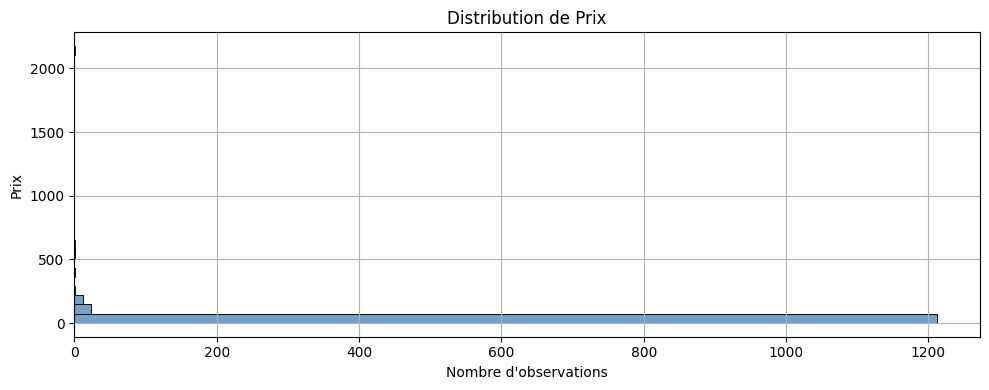

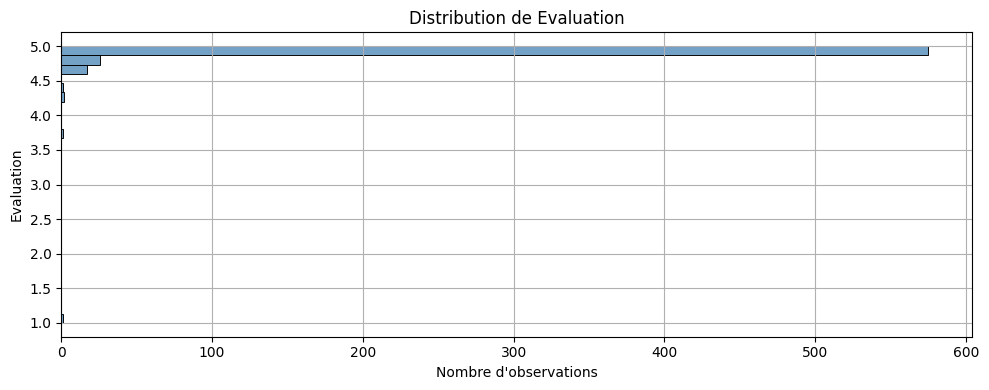

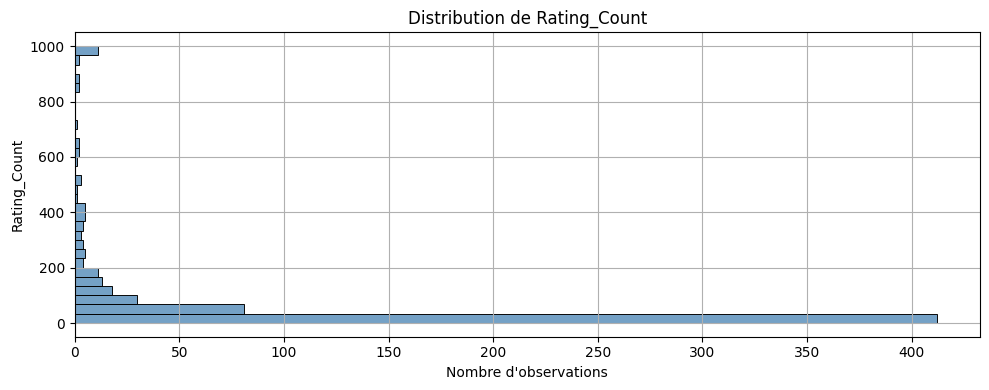

In [69]:
# 📊 Affichage des histogrammes horizontaux pour les colonnes numériques
for col in numeric_cols:
    
    # 🖼️ Initialisation de la figure
    plt.figure(figsize=(10, 4))
    
    # 🔍 Tracé de l'histogramme horizontal avec Seaborn
    sns.histplot(
        data=df,
        y=col,             # ➤ axe vertical : variable numérique
        bins=30,           # ➤ 30 classes (barres) pour la répartition
        color='steelblue', # ➤ Couleur des barres
        edgecolor='black'  # ➤ Contour des barres
    )
    
    # 🏷️ Personnalisation du graphique
    plt.title(f"Distribution de {col}")
    plt.ylabel(col)
    plt.xlabel("Nombre d'observations")
    plt.grid(True)
    plt.tight_layout()
    
    # 👁️ Affichage du graphique
    plt.show()

---

## 👥 16. Analyse de la répartition des vendeurs selon leur niveau

### ❓ 16.1. Pourquoi cette étape maintenant ?  

Après avoir exploré les variables numériques, il est essentiel de **décrire les variables catégorielles**, notamment celles pouvant servir à segmenter les analyses.  
La variable `Niveau` correspond à l’**expérience ou la réputation du vendeur** sur la plateforme Fiverr.  
C’est un critère de segmentation clé pour :

- Comparer les performances,
- Analyser les stratégies tarifaires,
- Évaluer l’offre par profil de vendeur.

### 🎯 16.2. Résultat attendu  

#### 📋 16.2.1. Visualisation des niveaux de vendeur

Un graphique en barres horizontales permet de :

- Visualiser **le nombre de services (gigs)** proposés par chaque niveau (`1 = Beginner`, `2 = Intermediate`, `3 = Expert`),
- Identifier une **sur- ou sous-représentation** d’un type de vendeur,
- Préparer des **analyses comparatives** (prix moyen, nombre d’évaluations…) selon le niveau.

---

### 🐍 16.3. Script d’analyse de la répartition des vendeurs

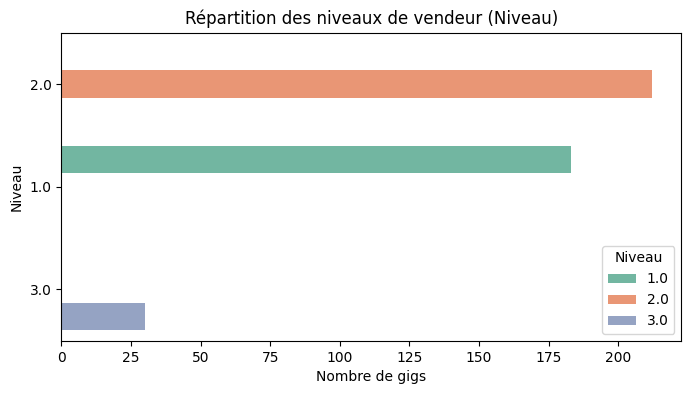

In [70]:
# 📊 Visualisation de la répartition des vendeurs selon leur niveau
plt.figure(figsize=(8, 4))

# ➤ Tracé d’un countplot horizontal avec couleur par catégorie
sns.countplot(
    data=df,
    y='Niveau',                                       # ➤ Axe vertical : catégories (niveaux de vendeur)
    hue='Niveau',                                     # ➤ Utilisé ici uniquement pour appliquer une couleur différente à chaque barre
    palette='Set2',                                   # ➤ Palette pastel harmonieuse
    order=df['Niveau'].value_counts().index           # ➤ Trie les niveaux du plus fréquent au moins fréquent
)

# 🏷️ Personnalisation
plt.title("Répartition des niveaux de vendeur (Niveau)")
plt.xlabel("Nombre de gigs")
plt.ylabel("Niveau")

# 👁️ Affichage
plt.show()

---

## 🧩 17. Imputation des valeurs manquantes de la variable catégorielle `Niveau` via KNN

### ❓ 17.1. Pourquoi cette étape maintenant ?

La variable `Niveau` contient encore des **valeurs manquantes**, alors qu’il s’agit d’un critère fondamental pour :

- segmenter les vendeurs selon leur expérience,
- effectuer des analyses comparatives ou des prédictions par profil.

Cependant, `Niveau` est une **variable catégorielle**, qui **ne peut pas être imputée directement comme une variable numérique**.  
Pour contourner cette contrainte, la stratégie retenue est la suivante :

1. **Encodage temporaire** avec `LabelEncoder` (`Beginner` → 0, `Intermediate` → 1, etc.),
2. **Imputation par KNN** à partir des variables numériques (`Prix`, `Evaluation`, `Rating_Count`) sur les lignes partiellement complètes,
3. **Décodage** des valeurs imputées pour retrouver les libellés d’origine.

Cette approche garantit une **cohérence statistique** tout en respectant la nature catégorielle de la variable.

### 🎯 17.2. Résultat attendu

- La colonne `Niveau` est **enrichie par estimation** à partir des voisins les plus proches.
- Les lignes ne pouvant pas être imputées de manière fiable restent en `NaN`.
- L'encodage temporaire est supprimé et remplacé par les libellés initiaux (`Beginner`, `Intermediate`, etc.).

---

### 🐍 17.3. Script d'imputation KNN

In [71]:
# 🔢 Étape 1 : Nettoyage et encodage temporaire de la variable catégorielle 'Niveau'
le = LabelEncoder()

# ➤ Standardisation des valeurs manquantes
df['Niveau'] = df['Niveau'].astype(str).str.strip().replace({
    '': np.nan,
    'nan': np.nan,
    'NaN': np.nan,
    'None': np.nan
})

# ➤ Encodage uniquement des lignes valides
mask_notna = df['Niveau'].notna()
df.loc[mask_notna, 'Level_encoded'] = le.fit_transform(df.loc[mask_notna, 'Niveau'])

# 🤖 Étape 2 : Imputation KNN sur les colonnes numériques + la variable encodée
cols_for_knn = ['Prix', 'Evaluation', 'Rating_Count', 'Level_encoded']
df_knn = df[cols_for_knn].copy()

# ➤ Initialisation et application du KNNImputer (k=5 voisins)
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=cols_for_knn, index=df.index)

# 🔁 Étape 3 : Reconversion de la variable encodée vers ses libellés d’origine
encoded = df_knn_imputed['Level_encoded'].round().astype('Int64')  # arrondi pour retrouver une classe discrète
encoded.index = df.index

# ➤ Sélection des valeurs encodées valides (dans le bon intervalle)
valid_range = list(range(len(le.classes_)))
mask_valid = encoded.isin(valid_range)

# ➤ Décodage des entiers vers les labels de niveau (Beginner, Intermediate, Expert)
niveau_imputes = pd.Series(index=df.index, dtype='object')
encoded_valid = encoded[mask_valid].astype(int)
niveau_imputes.loc[mask_valid] = le.inverse_transform(encoded_valid.to_numpy())

# ➤ Les lignes hors intervalle restent en NaN
niveau_imputes.loc[~mask_valid] = np.nan

# 🧩 Mise à jour du DataFrame original
df['Niveau'] = niveau_imputes
df.drop(['Level_encoded'], axis=1, inplace=True)

#***********************************************************************

# ➕ Étape 4 : Imputation des variables numériques restantes
cols_for_impute = ['Prix', 'Evaluation', 'Rating_Count']
df_impute = df[cols_for_impute].copy()

imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_impute)

df[cols_for_impute] = df_imputed  # remplacement dans le DataFrame original

print("Imputation terminée. Aucune valeur manquante dans les colonnes numériques sélectionnées.")

Imputation terminée. Aucune valeur manquante dans les colonnes numériques sélectionnées.


---

## ✅ 18. Vérification finale des valeurs manquantes après imputation

### ❓ 18.1. Pourquoi cette étape ?

Après avoir appliqué plusieurs méthodes d’imputation (KNN, encodage/décodage), il est essentiel de :
- vérifier qu’il ne reste **aucune valeur manquante** dans les colonnes critiques (`Prix`, `Evaluation`, `Rating_Count`, `Niveau`),
- valider visuellement que le **nettoyage est complet** et que le DataFrame est exploitable,
- s’assurer que le jeu de données est **prêt pour l’analyse et la modélisation**.

### 🎯 18.2. Résultat attendu

- Une **heatmap totalement vide (aucune zone colorée)** indiquant que toutes les cellules ont été remplies.
- Un affichage de **25 premières lignes** montrant une cohérence des colonnes `Description`, `Prix`, `Evaluation`, `Rating_Count` et `Niveau`.

---

### 🐍 18.3. Script de vérification

c:\wamp64\www\ia.follaco.fr\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


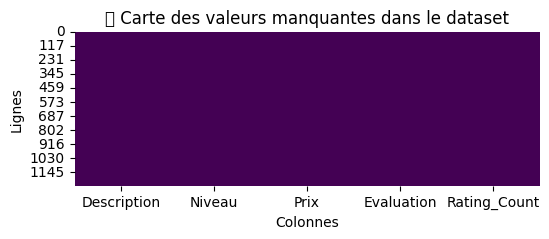

In [72]:
# 📊 Affichage visuel des valeurs manquantes après imputation finale
plt.figure(figsize=(6, 2))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('🌡️ Carte des valeurs manquantes dans le dataset')
plt.xlabel("Colonnes")
plt.ylabel("Lignes")
plt.show()

---

## 🧺 19. Suppression des lignes non exploitables (`Niveau == "Clients"`)

### ❓ 19.1. Pourquoi cette étape ?

Certaines lignes du dataset indiquent `"Clients"` dans la colonne `Niveau`, ce qui ne correspond **pas à un niveau de vendeur** mais plutôt à un acheteur ou à une erreur de saisie.

Ces lignes :
- n’apportent **aucune information utile** pour une analyse centrée sur les vendeurs,
- risquent de **perturber l’entraînement des modèles**,
- introduisent une **incohérence catégorielle** dans une variable censée représenter une hiérarchie de vendeurs.

### 🎯 19.2. Résultat attendu

- Toutes les lignes où `Niveau == "Clients"` sont supprimées.
- Le dataset est recentré uniquement sur les vendeurs (`Beginner`, `Intermediate`, `Expert`).
- La variable `Niveau` est désormais **cohérente avec la logique du projet**.

---

### 🐍 19.3. Script de nettoyage

In [73]:
# 1. Suppression des lignes où Niveau == "Clients"
df = df[df['Niveau'] != "Clients"]

---

## 20. 🔧 Nettoyage des données

### ❓ 20.1. Pourquoi cette étape maintenant ?  

À ce stade, les valeurs manquantes ont été traitées, les types de données corrigés et les variables clés sont prêtes pour l’analyse.  
Cependant, les **colonnes de type texte** (type `object`) peuvent contenir des **espaces en trop** (avant ou après les mots), ce qui fausse :

- les opérations de filtrage ou de groupement (`groupby`),
- la détection de doublons,
- les futurs encodages de variables catégorielles.

Cette étape assure une **standardisation des chaînes de caractères** avant toute modélisation ou visualisation.

### 🎯 20.2. Résultat attendu  

- Toutes les colonnes de type `object` sont nettoyées des **espaces superflus** en début et en fin de chaîne.
- Les valeurs textuelles sont prêtes pour les étapes d’analyse, de regroupement ou de vectorisation.
- Aucun espace parasite ne viendra perturber l’analyse statistique ou la modélisation.

### 🐍 20.3. Script de nettoyage

In [74]:
# 🔧 Nettoyage des colonnes textuelles : suppression des espaces en début/fin de chaîne

# ➤ Sélectionne toutes les colonnes de type texte (object ou string)
for col in df.select_dtypes(include='object').columns:
    # ➤ Convertit en string puis supprime les espaces en début et fin
    df[col] = df[col].astype(str).str.strip()

# 🔎 Affiche un aperçu après nettoyage
df.head(2)

,Description,Niveau,Prix,Evaluation,Rating_Count
0,i will do excel formulas vba macros charts for...,2.0,8.701,5.0,56.0
1,i will do data mining web scraping data extrac...,3.0,3.263,5.0,1000.0


---

## 📈 21. Visualisation des distributions

### ❓ 21.1. Pourquoi cette étape maintenant ?

Une fois les données nettoyées et les valeurs manquantes imputées, il est essentiel de **visualiser la répartition des variables numériques**. Cela permet de :

- Comprendre la **forme des distributions** (symétrie, asymétrie, concentration),
- Détecter d’éventuelles **valeurs aberrantes persistantes**,
- Identifier des **zones de densité ou de rareté**,
- Adapter le traitement des variables aux futures étapes (normalisation, discrétisation, etc.).

Cette étape consolide la compréhension globale du dataset avant la phase de modélisation.

### 🎯 21.2. Résultat attendu

Pour chaque variable numérique (`Prix`, `Rating_Count`, `Evaluation`) :

- Un histogramme adapté avec :
  - des limites d’axe personnalisées pour éviter l’écrasement visuel par les valeurs extrêmes,
  - un nombre de classes (`bins`) ajusté,
  - une courbe de densité (`kde=True`) pour visualiser la forme réelle de la distribution,
  - une orientation adaptée (verticale pour `Evaluation`, horizontale pour les autres).

> 🔧 À noter : un **graphique spécial à échelle fractionnée** est également prévu pour `Evaluation` (code commenté), utile en cas de distribution fortement déséquilibrée.

### 🐍 21.3. Script de la visualisation des distributions

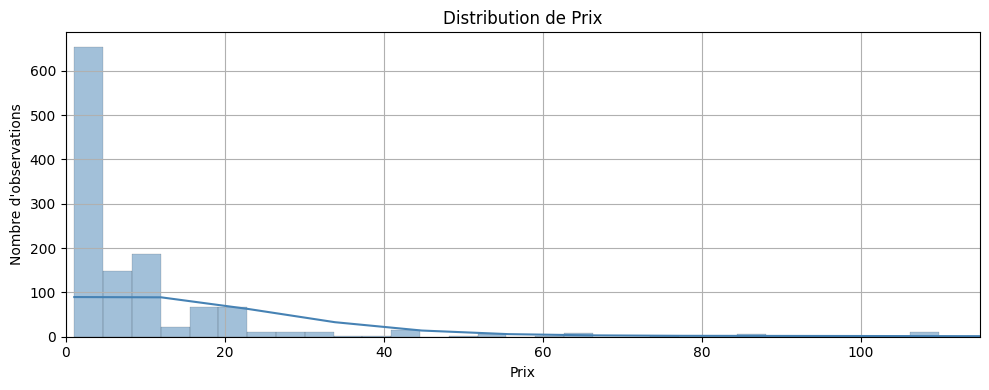

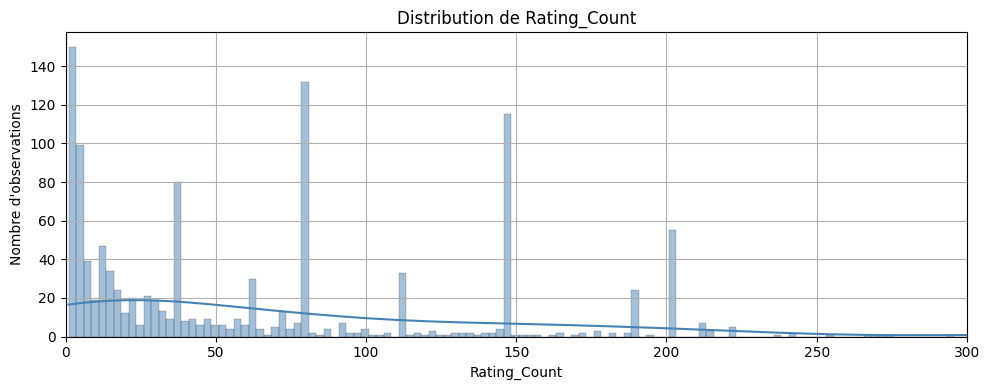

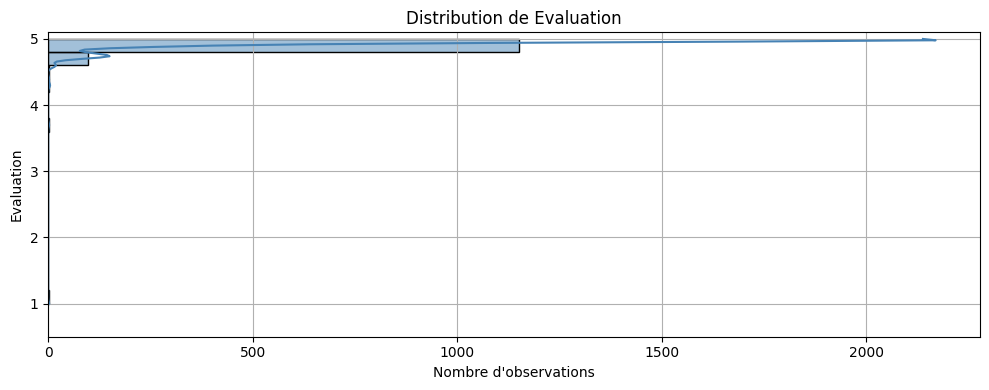

In [75]:
# 📌 Affichage des histogrammes avec orientation personnalisée + échelle fractionnée

# 1️⃣ Colonnes numériques à analyser
numerical_cols = ['Prix', 'Rating_Count', 'Evaluation']

# 2️⃣ Limites personnalisées pour les axes (zoom sur les zones denses)
x_limits = {
    'Prix': (0, 115),            # Échelle réaliste des prix
    'Rating_Count': (0, 300),    # Limite les avis extrêmes
    'Evaluation': (0.5, 5.1)     # Barème de notation standard de 1 à 5
}

# 3️⃣ Définition du nombre de classes (bins) selon les variables
bins_dict = {
    'Prix': 600,
    'Rating_Count': 400,
    'Evaluation': 20
}

# 4️⃣ Boucle sur chaque variable pour générer un histogramme
for col in numerical_cols:
    plt.figure(figsize=(10, 4))  # Dimensions du graphique

    if col == 'Evaluation':
        # 🔹 Affichage vertical pour la variable Evaluation
        sns.histplot(
            data=df,
            y=col,
            kde=True,
            bins=bins_dict.get(col, 30),
            color='steelblue',
            edgecolor='black'
        )
        plt.ylabel(col)
        plt.xlabel("Nombre d'observations")
        if col in x_limits:
            plt.ylim(x_limits[col])

    else:
        # 🔹 Affichage horizontal pour Prix et Rating_Count
        sns.histplot(
            data=df,
            x=col,
            kde=True,
            bins=bins_dict.get(col, 30),
            color='steelblue',
            edgecolor='black'
        )
        plt.xlabel(col)
        plt.ylabel("Nombre d'observations")
        if col in x_limits:
            plt.xlim(x_limits[col])

    # 🎨 Mise en forme
    plt.title(f"Distribution de {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

---

## 🧮 22. Création d’un indicateur synthétique de **fiabilité**

### ❓ 22.1. Pourquoi cette étape maintenant ?  
Les colonnes `Evaluation` et `Rating_Count` sont deux indicateurs importants mais **corrélés**.  
Plutôt que de les traiter séparément, on les fusionne dans un **indice synthétique de fiabilité** qui reflète à la fois :
- la **note moyenne** du service (sur 5),
- et la **confiance qu'on peut accorder** à cette note en fonction du nombre d’avis (plus il y a d’avis, plus c’est fiable).

Cette transformation permet :
- de **réduire la dimensionnalité** sans perte d’information,
- de **pondérer les notes subjectives** par leur niveau de confiance,
- de créer une variable très utile pour la **modélisation prédictive**.

---

### 🐍 22.2. Script de la méthode de calcul

In [76]:
# 🧮 Création de la colonne 'Fiabilite'

# Formule utilisée :
# - Normalisation de la note sur 5 étoiles : Evaluation / 5
# - Pondération par une fonction logarithmique croissante du nombre d’avis :
#     (1 - 1 / (1 + log(1 + Rating_Count)))
# - Objectif : accorder davantage de fiabilité aux évaluations soutenues par un grand nombre d'avis

df['Fiabilite'] = (df['Evaluation'] / 5) * (1 - 1 / (1 + np.log1p(df['Rating_Count'])))

# 🔁 Suppression des colonnes devenues redondantes
df.drop(['Evaluation', 'Rating_Count'], axis=1, inplace=True)

print("✅ Colonne 'Fiabilite' créée et colonnes d'origine supprimées")
display(df.head(5))

✅ Colonne 'Fiabilite' créée et colonnes d'origine supprimées


,Description,Niveau,Prix,Fiabilite
0,i will do excel formulas vba macros charts for...,2.0,8.701,0.801707
1,i will do data mining web scraping data extrac...,3.0,3.263,0.873558
2,i will do web scraping data scraping scraping ...,2.0,2.176,0.806160
3,i will do python web scraping data entry and d...,2.0,1.088,0.848192
4,i will data scraping web site scraping and dat...,2.0,4.351,0.831973


---

## 🧹 23. Nettoyage avancé de la colonne `Description` : suppression des mots inutiles (stopwords)

### ❓ 23.1. Pourquoi cette étape maintenant ?  

Après avoir standardisé les textes (minuscules, accents, ponctuation), il reste encore des éléments qui **polluent l’analyse sémantique** :  
- Des **formules répétitives** en anglais ("I will do...", "I can...", etc.),
- Des **mots très fréquents mais peu informatifs** (appelés *stopwords*), comme : “je”, “vous”, “le”, “dans”, etc.

Ces éléments doivent être retirés pour :
- améliorer la qualité des futurs **embeddings ou vectorisations**,
- éviter que les modèles soient biaisés par des mots inutiles,
- **condenser l’information utile** contenue dans la description.

### 🎯 23.2. Résultat attendu  

- Les **descriptions sont nettoyées**, ne contenant que les mots significatifs.
- Les formules stéréotypées en anglais sont supprimées.
- Les stopwords français sont filtrés automatiquement.
- Le texte est plus concis, utile et adapté à un usage de modélisation NLP.

---

### 🐍 23.3. Script de nettoyage des descriptions

In [77]:
# 📥 Téléchargement des stopwords français depuis NLTK (à faire une seule fois)
nltk.download('stopwords')
french_stopwords = stopwords.words('french')

# 🔧 Fonction de nettoyage approfondi des descriptions textuelles
def clean_description(text):
    # 1. Mise en minuscules
    text = text.lower()
    
    # 2. Suppression de la ponctuation et des caractères spéciaux
    text = re.sub(r'[^a-zA-ZÀ-ÿ0-9\s]', '', text)
    
    # 3. Suppression de débuts de phrases typiques (formules Fiverr)
    phrases_to_remove = [
        r"^i\s+will\s+do\s+",         # Ex. : "I will do your logo" → supprime "I will do"
        r"^i\s+will\s+create\s+",     # Ex. : "I will create a website" → supprime "I will create"
        r"^i\s+will\s+be\s+your\s+",  # Ex. : "I will be your virtual assistant" → supprime "I will be your"
        r"^i\s+will\s+write\s+",      # Ex. : "I will write blog posts" → supprime "I will write"
        r"^i\s+will\s+provide\s+",    # Ex. : "I will provide SEO services" → supprime "I will provide"
        r"^i\s+will\s+design\s+",     # Ex. : "I will design your flyer" → supprime "I will design"
        r"^i\s+can\s+",               # Ex. : "I can help you" → supprime "I can"
        r"^i\s+am\s+going\s+to\s+",   # Ex. : "I am going to create..." → supprime "I am going to"
        r"^i\s+will\s+",              # Expression générique pour capturer les cas restants comme "I will edit"
    ]

    # 4. Suppression des phrases définies
    for pattern in phrases_to_remove:
        text = re.sub(pattern, "", text, flags=re.IGNORECASE)
    
    # 5. Suppression des stopwords français
    words = [word for word in text.split() if word not in french_stopwords]
    
    # 6. Reconstruction du texte nettoyé
    return " ".join(words).strip()

# 🧹 Application de la fonction à la colonne 'Description'
df["Description_cleaned"] = df["Description"].astype(str).apply(clean_description)
df["Description"] = df["Description_cleaned"]
df.drop(columns=["Description_cleaned"], inplace=True)  # Nettoyage intermédiaire

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lfoll\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---

## 📊 24. Analyse exploratoire : Prix, Niveau et Fiabilité

### ❓ 24.1. Quel est l’objectif de cette analyse ?

Dans cette étape, nous cherchons à comprendre comment le **niveau du vendeur** et sa **fiabilité** influencent le **prix** des services proposés. Trois approches complémentaires sont mobilisées pour explorer ces relations.

### 📈 24.2. Prix moyen par niveau de vendeur

Le tableau généré affiche le **prix moyen** pour chaque catégorie de vendeur (`Nouveau`, `Confirmé`, `Top`).  
Cela permet de vérifier si un **niveau plus élevé est associé à des prix plus importants**, ce qui refléterait une valorisation de l’expérience ou de la réputation.

### 🔗 24.3. Corrélation entre Prix et Fiabilité

Un tableau de **corrélation de Pearson** met en évidence le lien linéaire entre la **fiabilité du vendeur** (score numérique) et le **prix**.  
Une valeur proche de `+1` indiquerait que les vendeurs plus fiables ont tendance à fixer des prix plus élevés.

### 📉 24.4. Visualisation : nuage de points Prix vs Fiabilité

Le nuage de points ci-dessous **illustre visuellement cette relation**. Chaque point représente un service :  
- L’axe horizontal correspond à la **fiabilité** du vendeur.  
- L’axe vertical correspond au **prix** du service.  

Cette visualisation permet d’identifier des **tendances générales**, des **valeurs atypiques** ou des **groupes de vendeurs**.

---

### 🐍 24.5. Script d’analyse exploratoire

📊 Affichage du prix moyen par niveau de vendeur


Niveau
1.0     6.850182
2.0    24.951446
3.0    16.546929
Name: Prix, dtype: float64



📈 Affichage de la corrélation entre Prix et Fiabilité


,Prix,Fiabilite
Prix,1.000000,-0.018182
Fiabilite,-0.018182,1.000000




📉 Affichage du nuage de points entre Fiabilité et Prix


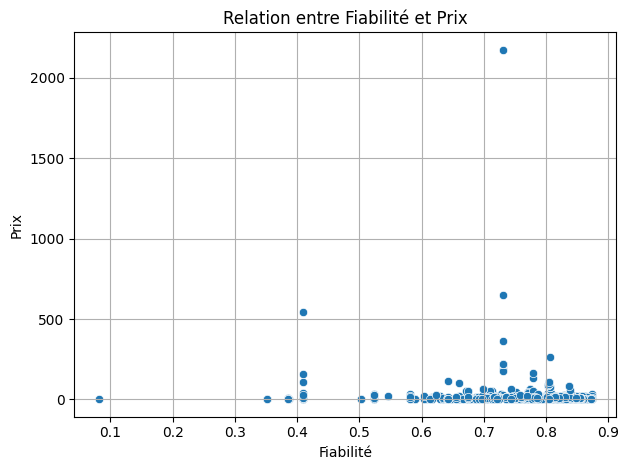

In [78]:
# 📊 Affichage du prix moyen par niveau de vendeur
print("📊 Affichage du prix moyen par niveau de vendeur")

# ➕ Calcul du prix moyen pour chaque niveau de vendeur
# - groupby("Niveau") : regroupe les données par type de vendeur
# - ["Prix"].mean() : calcule la moyenne des prix pour chaque groupe
# - display(...) : affiche le tableau dans un format lisible (Jupyter)
display(df.groupby("Niveau")["Prix"].mean())


# 📈 Affichage de la corrélation entre Prix et Fiabilité
print("\n\n📈 Affichage de la corrélation entre Prix et Fiabilité")

# 🔗 Corrélation de Pearson entre Prix et Fiabilité
# - [["Prix", "Fiabilite"]] : sélection des colonnes pertinentes
# - .corr() : retourne une matrice 2x2 avec les coefficients de corrélation
display(df[["Prix", "Fiabilite"]].corr())


# 📉 Affichage du nuage de points Prix vs Fiabilité
print("\n\n📉 Affichage du nuage de points entre Fiabilité et Prix")

# 🎯 Nuage de points pour visualiser la relation Prix ~ Fiabilité
# - Chaque point représente un service
# - Axes : x = Fiabilité, y = Prix
sns.scatterplot(
    x="Fiabilite",
    y="Prix",
    data=df
)

# ➕ Personnalisation du graphique
plt.title("Relation entre Fiabilité et Prix")
plt.xlabel("Fiabilité")
plt.ylabel("Prix")
plt.grid(True)
plt.tight_layout()
plt.show()

---

## 💾 25. Export du fichier nettoyé

### ❓ 25.1. Pourquoi cette étape maintenant ?  
Après avoir réalisé l’ensemble des étapes de nettoyage et d’imputation, le DataFrame est désormais **propre, complet et prêt à être exploité**.  
Il est donc essentiel de **sauvegarder ce jeu de données nettoyé** afin de :

- ne pas répéter les traitements à chaque exécution,
- disposer d’un jeu de données stable pour les futures analyses,
- faciliter le partage ou la réutilisation dans des scripts de modélisation.

### 🎯 25.2. Résultat attendu  
Deux fichiers sont générés dans le dossier `data/` :

| Format    | Fichier                        | Avantages                                 |
|-----------|--------------------------------|--------------------------------------------|
| `.csv`    | `fiverr_cleaned.csv`           | Simple, universel, lisible partout         |
| `.parquet`| `fiverr_cleaned.parquet`       | Compressé, rapide à charger, typé         |

- Les deux fichiers sont **sans index**.
- Le `.csv` est encodé en **UTF-8** pour garantir la compatibilité.
- Le `.parquet` utilise le moteur **pyarrow** avec compression **Snappy** (rapide, léger).

---

### 🐍 25.3. Script d’export des données nettoyées

In [79]:
# 💾 Exportation du DataFrame nettoyé dans un fichier CSV
df.to_csv(
    'data/fiverr_cleaned.csv',  # 📁 Chemin et nom du fichier de sortie
    index=False,                # ❌ On exclut l'index pour ne pas l'écrire dans le fichier
    encoding='utf-8'            # 🌐 Encodage universel pour garantir la compatibilité
)

# 💾 Exportation du même DataFrame au format Parquet (plus rapide, compressé)
df.to_parquet(
    'data/fiverr_cleaned.parquet',  # 📁 Chemin et nom du fichier Parquet
    index=False,                    # ❌ Pas d'index également
    engine='pyarrow',               # 🚀 Moteur recommandé pour compatibilité large
    compression='snappy'           # 📦 Compression légère et rapide
)

print("✅ Données exportées dans :")
print("- data/fiverr_cleaned.csv")
print("- data/fiverr_cleaned.parquet")

✅ Données exportées dans :
- data/fiverr_cleaned.csv
- data/fiverr_cleaned.parquet


---

## 🔄 26. Transformation avancée des données pour la modélisation

### ❓ 26.1. Pourquoi effectuer ces transformations ?

Avant d’entraîner nos modèles, certaines **transformations préparatoires** sont nécessaires pour :
- Corriger les **valeurs extrêmes** pouvant fausser l’apprentissage,
- Convertir les **variables qualitatives en format numérique**,
- Renforcer certaines variables comme la **fiabilité**, en la pondérant selon le niveau,
- Stabiliser la distribution des prix via une **transformation logarithmique**.

Ces étapes permettent d’**améliorer la qualité du signal** et la performance des futurs algorithmes.

### ⚙️ 26.2. Détail des transformations appliquées

- **Suppression des outliers** sur la variable `Prix` par la méthode IQR.
- **Encodage ordinal** du niveau de vendeur : Beginner (1), Intermediate (2), Expert (3).
- **Pondération de la fiabilité** en la multipliant par le niveau.
- **Transformation logarithmique** du prix pour lisser sa distribution et atténuer l’influence des valeurs extrêmes.

### 💾 26.3. Résultat obtenu

- Un fichier `fiverr_cleaned_transformed.csv` est généré dans le dossier `data/`.
- Il contient les variables transformées et prêtes à être utilisées dans les modèles de régression ou de classification.

---

### 🐍 26.4. Script de transformation des données

In [80]:
# 📦 Traitement des données — Nettoyage et transformation pour modélisation

# 1. 📥 Chargement du fichier source
df = pd.read_csv("data/fiverr_cleaned.csv")

# 2. 🧹 Suppression des valeurs aberrantes (outliers) dans la colonne "Prix" selon la méthode de l'IQR
q1 = df["Prix"].quantile(0.25)                   # Premier quartile
q3 = df["Prix"].quantile(0.75)                   # Troisième quartile
iqr = q3 - q1                                     # Intervalle interquartile
lower_bound = q1 - 1.5 * iqr                      # Borne inférieure
upper_bound = q3 + 1.5 * iqr                      # Borne supérieure
df = df[(df["Prix"] >= lower_bound) & (df["Prix"] <= upper_bound)]  # Filtrage des données

# 3. 🔢 Encodage numérique de la colonne "Niveau"
# Les niveaux sont convertis en entiers croissants
df["Niveau"] = df["Niveau"].replace({
    "Beginner": 1,
    "Intermediate": 2,
    "Expert": 3
}).astype(int)

# 4. 🎯 Pondération de la fiabilité par le niveau du vendeur
# Cela crée un score composite intégrant les deux dimensions
df["Fiabilite"] = df["Fiabilite"] * df["Niveau"]

# 5. 🔁 Transformation logarithmique du prix
# np.log1p(x) = log(1 + x), utile pour atténuer les écarts extrêmes tout en conservant les zéros
df["Prix_log"] = np.log1p(df["Prix"])

# 6. 💾 Sauvegarde des données transformées
df.to_csv(
    'data/fiverr_cleaned_transformed.csv',  # 📁 Chemin et nom du fichier de sortie
    index=False,                # ❌ On exclut l'index pour ne pas l'écrire dans le fichier
    encoding='utf-8'            # 🌐 Encodage universel pour garantir la compatibilité
)

# 💾 Exportation du même DataFrame au format Parquet (plus rapide, compressé)
df.to_parquet(
    'data/fiverr_cleaned_transformed.parquet',  # 📁 Chemin et nom du fichier Parquet
    index=False,                    # ❌ Pas d'index également
    engine='pyarrow',               # 🚀 Moteur recommandé pour compatibilité large
    compression='snappy'           # 📦 Compression légère et rapide
)

print("✅ Données transformées et sauvegardées dans : data/fiverr_cleaned_transformed.csv")

✅ Données transformées et sauvegardées dans : data/fiverr_cleaned_transformed.csv


---

## 📊 27. Visualisation après nettoyage des outliers

### ❓ 27.1. Quel est l’objectif de cette visualisation ?

Une fois les valeurs extrêmes supprimées de la variable `Prix`, il est important de **réévaluer les relations statistiques** dans un contexte plus fiable.  
Ces visualisations permettent de **vérifier l'impact du nettoyage** et de détecter des tendances plus nettes sans perturbation des outliers.

### 📈 27.2. Indicateurs analysés

1. **Prix moyen par niveau de vendeur**  
   Cette statistique permet de confirmer si les vendeurs expérimentés continuent à proposer des prix plus élevés **après filtrage** des valeurs extrêmes.

2. **Corrélation entre Prix et Fiabilité**  
   Le coefficient de corrélation met en évidence la **relation linéaire** entre la fiabilité (pondérée) et le prix, dans un environnement de données assainies.

3. **Nuage de points Prix vs Fiabilité**  
   Cette représentation graphique offre une **vue visuelle de la distribution des prix** en fonction du niveau de fiabilité, sans influence des cas extrêmes.  
   Elle permet d’observer les tendances générales et les éventuelles zones de concentration.

---

### 🐍 27.3. Script de visualisation post-nettoyage

📊 Affichage du prix moyen par niveau de vendeur


Niveau
1     5.886709
2     6.419340
3    14.078361
Name: Prix, dtype: float64



📈 Affichage de la corrélation entre Prix et Fiabilité


,Prix,Fiabilite
Prix,1.000000,0.125243
Fiabilite,0.125243,1.000000




📉 Affichage du nuage de points entre Fiabilité et Prix


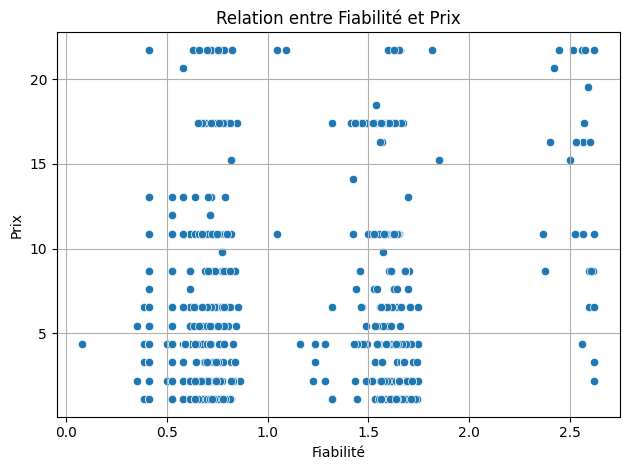

In [81]:
print("📊 Affichage du prix moyen par niveau de vendeur")
display(df.groupby("Niveau")["Prix"].mean())

print("\n\n📈 Affichage de la corrélation entre Prix et Fiabilité")
display(df[["Prix", "Fiabilite"]].corr())

print("\n\n📉 Affichage du nuage de points entre Fiabilité et Prix")
sns.scatterplot(
    x="Fiabilite",
    y="Prix",
    data=df
)

# ➕ Personnalisation du graphique
plt.title("Relation entre Fiabilité et Prix")
plt.xlabel("Fiabilité")
plt.ylabel("Prix")
plt.grid(True)
plt.tight_layout()
plt.show()

---

## 🔍 28. Analyse comparative avant et après suppression des outliers

### 📌 28.1. Objectif de la comparaison

Cette section vise à **évaluer l’impact du nettoyage des valeurs aberrantes** sur les statistiques descriptives et la lisibilité des données.  
Les analyses sont comparées selon trois axes : les moyennes par niveau, la corrélation Prix–Fiabilité et le nuage de points.

### 📊 28.2. Prix moyen par niveau

| Niveau         | Prix moyen (avant) | Prix moyen (après) | Évolution        |
|----------------|--------------------|---------------------|------------------|
| 🟢 Beginner     | 6.85               | 5.89                | 🔻 légère baisse |
| 🟡 Intermediate | 24.95              | 6.42                | 🔻 forte baisse  |
| 🔴 Expert       | 16.55              | 14.08               | 🔻 modérée       |

🔎 **Interprétation** :  
Les valeurs extrêmes affectaient fortement la moyenne des vendeurs de niveau *intermédiaire*. Leur suppression donne une vision plus réaliste de la tarification par niveau.

### 📈 28.3. Corrélation entre Prix et Fiabilité

|                | Corrélation (avant) | Corrélation (après) |
|----------------|---------------------|----------------------|
| 💬 Prix–Fiabilité | -0.018              | +0.125               |

🔎 **Interprétation** :  
La corrélation initialement quasi nulle devient **légèrement positive**, révélant une relation plus logique : **plus un vendeur est fiable, plus son prix tend à être élevé**.

### 📉 28.4. Nuage de points : Prix vs Fiabilité

#### 📉 Nuage de points avant nettoyage
![Avant nettoyage](img/before_outliers_cleaned.png)

#### 📈 Nuage de points après nettoyage
![Après nettoyage](img/after_outliers_cleaned.png)

🔎 **Interprétation visuelle** :  
- Avant traitement : forte **dispersion verticale**, présence de **valeurs très extrêmes** (> 2000) masquant les tendances générales.
- Après nettoyage : meilleure **concentration des points**, structure plus lisible, et **répartition plus homogène** selon la fiabilité.

### ✅ 28.5. Conclusion

Le nettoyage des outliers **améliore considérablement la qualité descriptive et visuelle** des données.  
Les tendances deviennent plus **cohérentes**, plus **interprétables** et donc plus fiables pour les futures étapes de modélisation.


---
## 🧾 29. Conclusion du prétraitement

Ce notebook a permis de préparer rigoureusement le jeu de données **"Fiverr Gigs"** en vue d’une phase de **modélisation fiable et performante**.

🔧 **Étapes clés réalisées** :

- Exploration initiale du dataset : dimensions, types, valeurs manquantes, doublons
- Nettoyage des colonnes textuelles et numériques (`Prix`, `Description`, etc.)
- Imputation contextuelle des valeurs manquantes par la méthode des **K plus proches voisins (KNN)**, appliquée aussi bien aux variables numériques qu’à la variable catégorielle `Niveau`
- Analyses visuelles approfondies : heatmaps, boxplots, histogrammes orientés, échelles fractionnées
- Finalisation du dataset : types cohérents, valeurs complètes, sauvegarde au format CSV prêt à l’emploi

🎯 **Résultat** :

Les données sont désormais **propres, cohérentes et exploitables**, prêtes à être utilisées dans les prochaines étapes d’**analyse exploratoire approfondie** ou d’**entraînement de modèles de machine learning**.

---
## ✅ 30. Checklist de fin de prétraitement des données

| Étape                                   | Description                                                                                                 | Statut |
|----------------------------------------|-------------------------------------------------------------------------------------------------------------|--------|
| 📥 **Téléchargement du dataset**        | Récupération automatisée depuis Kaggle via `kagglehub`                                                      | ✅     |
| 📂 **Chargement du fichier CSV**        | Lecture dans un DataFrame avec encodage `utf-8`                                                             | ✅     |
| 🧽 **Renommage des colonnes**           | Nettoyage des noms de colonnes (suppression de caractères parasites, ex. `ï»¿`)                             | ✅     |
| 🧹 **Nettoyage des chaînes**            | Suppression des espaces superflus avec `.str.strip()`                                                       | ✅     |
| 🏷️ **Conversion des types**            | Conversion en `float` pour `Prix`, `Evaluation`, `Rating_Count`                                             | ✅     |
| 💶 **Nettoyage des prix**               | Suppression des symboles monétaires (€/$) et remplacement des virgules par des points                       | ✅     |
| ❌ **Suppression de colonnes inutiles** | Suppression de la colonne `gigrating` devenue redondante                                                    | ✅     |
| 🔎 **Analyse exploratoire initiale**    | Analyse des dimensions, types, valeurs manquantes, doublons, unicité des colonnes                           | ✅     |
| 📊 **Visualisation des distributions**  | Histogrammes des variables numériques + zoom avec échelle fractionnée (`Evaluation`)                        | ✅     |
| 📈 **Analyse des niveaux vendeurs**     | Countplot horizontal de la variable `Niveau` (vendeurs Fiverr)                                              | ✅     |
| 🧪 **Détection des outliers**           | Boxplots sur `Prix`, `Evaluation` et `Rating_Count` pour visualiser les valeurs extrêmes                    | ✅     |
| 🧠 **Imputation KNN - Numérique**       | Imputation des colonnes numériques par KNN (`k=5`)                                                           | ✅     |
| 🧠 **Imputation KNN - Catégorielle**    | Encodage + imputation KNN sur `Niveau` + décodage inverse (LabelEncoder)                                    | ✅     |
| ✏️ **Nettoyage final des chaînes**      | Harmonisation des champs textuels (`Description`, `Niveau`, etc.)                                           | ✅     |
| 💾 **Export du fichier nettoyé**        | Sauvegarde du fichier `.csv` finalisé (`utf-8`, sans index) dans `data/fiverr_cleaned.csv`                  | ✅     |